In [1]:
import jax
jax.config.update('jax_enable_x64', True)
import jax.scipy as jsp
import jax.numpy as jnp
import numpy as np

from scipy.stats import gaussian_kde

import blackjax
from blackjax.types import ArrayTree
import optax
from optax._src.base import OptState
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 10

from typing import NamedTuple
from fastprogress import progress_bar

rng_key = jax.random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Code is adapted from https://blackjax-devs.github.io/sampling-book/algorithms/cyclical_sgld.html and https://github.com/ruqizhang/csgmcmc

In [2]:
# same setting as in Zhang et al. 2019
positions = jnp.asarray([-4, -2, 0, 2, 4])
means = jnp.asarray(jnp.meshgrid(positions, positions)).reshape(2, -1).T
cov = 0.1 * jnp.eye(2)

@jax.jit
def logprob_fn(x, *_):
    return jnp.sum(
        jnp.log(1 / means.shape[0])
        + jsp.special.logsumexp(
            jsp.stats.multivariate_normal.logpdf(x, means, cov), axis=-1
        )
    )

@jax.jit
def sample_fn(rng_key):
    """Sample from the Gaussian Mixture Model."""
    choose_key, sample_key = jax.random.split(rng_key)
    samples = jax.random.multivariate_normal(sample_key, means, cov)
    return jax.random.choice(choose_key, samples)

### SGLD

In [3]:
# 5k iterations
num_training_steps = 50000
schedule_fn_sgld = lambda k: 0.05 * k ** (-0.55)
schedule_sgld = schedule_fn_sgld(np.arange(1, num_training_steps+1))

grad_fn = lambda x, _: jax.grad(logprob_fn)(x)
sgld = blackjax.sgld(grad_fn)

rng_key = jax.random.PRNGKey(0)
rng_key, init_key = jax.random.split(rng_key)
init_position = -10 + 20 * jax.random.uniform(init_key, shape=(2,))

position = sgld.init(init_position)
sgld_samples = []
for i in progress_bar(range(num_training_steps)):
    rng_key, sample_key = jax.random.split(rng_key)
    position = jax.jit(sgld.step)(sample_key, position, 0, schedule_sgld[i])
    sgld_samples.append(position)
sgld_samples = np.asarray(sgld_samples)

In [4]:
class ScheduleState(NamedTuple):
    step_size: float
    do_sample: bool

def build_schedule(
    num_training_steps,
    num_cycles=4,
    initial_step_size=1e-3,
    exploration_ratio=0.25,
    step_size_sampling=1e-3
):
    cycle_length = num_training_steps // num_cycles

    def cosine_schedule(step_id):
        do_sample = False
        if ((step_id % cycle_length)/cycle_length) >= exploration_ratio:
            do_sample = True

        cos_out = jnp.cos(jnp.pi * (step_id % cycle_length) / cycle_length) + 1
        step_size = 0.5 * cos_out * initial_step_size

        return ScheduleState(step_size.item(), do_sample)
    
    def constant_schedule(step_id):
        do_sample = False
        if ((step_id % cycle_length) / cycle_length) >= exploration_ratio:
            do_sample = True

        if not do_sample:
            step_size = initial_step_size
        else:
            step_size = step_size_sampling

        return ScheduleState(step_size, do_sample)

    return cosine_schedule, constant_schedule

class CyclicalSGMCMCState(NamedTuple):
    """State of the Cyclical SGMCMC sampler.
    """
    position: ArrayTree
    opt_state: OptState


def cyclical_sgld(grad_estimator_fn, loglikelihood_fn):

    # Initialize the SgLD step function
    sgld = blackjax.sgld(grad_estimator_fn)
    sgd = optax.sgd(1.)

    def init_fn(position):
        opt_state = sgd.init(position)
        return CyclicalSGMCMCState(position, opt_state)

    def step_fn(rng_key, state, minibatch, schedule_state):
        """Cyclical SGLD kernel."""

        def step_with_sgld(current_state):
            rng_key, state, minibatch, step_size = current_state
            new_position = sgld.step(rng_key, state.position, minibatch, step_size)
            return CyclicalSGMCMCState(new_position, state.opt_state)

        def step_with_sgd(current_state):
            _, state, minibatch, step_size = current_state
            grads = grad_estimator_fn(state.position, 0)
            rescaled_grads = - 1. * step_size * grads
            updates, new_opt_state = sgd.update(
                rescaled_grads, state.opt_state, state.position
                )
            new_position = optax.apply_updates(state.position, updates)
            return CyclicalSGMCMCState(new_position, new_opt_state)

        new_state = jax.lax.cond(
            schedule_state.do_sample,
            step_with_sgld,
            step_with_sgd,
            (rng_key, state, minibatch, schedule_state.step_size)
        )

        return new_state

    return init_fn, step_fn

### Schedule functions

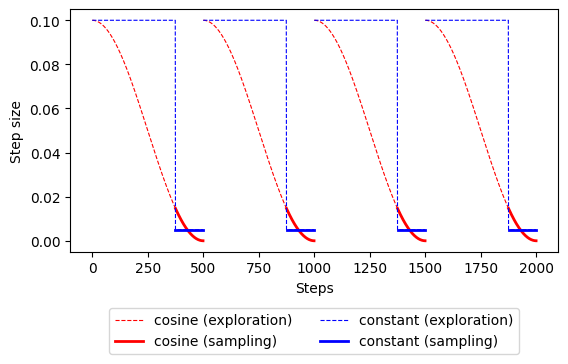

In [ ]:
m = 4
cosine_schedule, constant_schedule = build_schedule(2000, m, 1e-1, 0.75, 0.005)
schedule_cos = [cosine_schedule(i) for i in range(2000)]
schedule_const = [constant_schedule(i) for i in range(2000)]
step_sizes_cos = np.array([step.step_size for step in schedule_cos])
step_sizes_const = np.array([step.step_size for step in schedule_const])
do_sample = np.array([step.do_sample for step in schedule_cos])

sampling_points_cos = np.ma.masked_where(~do_sample, step_sizes_cos)
sampling_points_const = np.ma.masked_where(~do_sample, step_sizes_const)

fig, ax = plt.subplots(figsize=(6.3, 6.3/2))
# ax.plot(step_sizes1, lw=1, ls="--", color="r", label="Exploration stage")
# ax.plot(sampling_points1, lw=1, ls="-", color="r", label="Sampling stage")
# ax.plot(step_sizes2, lw=1, ls="--", color="b", label="Exploration stage (step size sampling)")
# ax.plot(sampling_points2, lw=1, ls="-", color="b", label="Sampling stage (step size sampling)")

ax.set_xlabel("Steps")
ax.set_ylabel("Step size")

for i in range(m):
    step_sizes_cos_i = step_sizes_cos[i * (2000 // m):(i + 1) * (2000 // m)]
    sampling_points_cos_i = sampling_points_cos[i * (2000 // m):(i + 1) * (2000 // m)]
    step_sizes_const_i = step_sizes_const[i * (2000 // m):(i + 1) * (2000 // m)]
    sampling_points_const_i = sampling_points_const[i * (2000 // m):(i + 1) * (2000 // m)]
    xs = np.arange(i * (2000 // m), (i + 1) * (2000 // m))
    ax.plot(xs, step_sizes_cos_i, lw=0.8, ls="--", color="r")
    ax.plot(xs, sampling_points_cos_i, lw=2, ls="-", color="r")
    ax.plot(xs, step_sizes_const_i, lw=0.8, ls="--", color="b")
    ax.plot(xs, sampling_points_const_i, lw=2, ls="-", color="b")
    # ax.axvline(i * (2000 // m), color="k", lw=1, ls="-")
# ax.axvline(2000, color="k", lw=1, ls="-")
handles = [
    plt.Line2D([], [], color="r", lw=0.8, ls="--", label="cosine (exploration)"),
    plt.Line2D([], [], color="r", lw=2, ls="-", label="cosine (sampling)"),
    plt.Line2D([], [], color="b", lw=0.8, ls="--", label="constant (exploration)"),
    plt.Line2D([], [], color="b", lw=2, ls="-", label="constant (sampling)"),
]
ax.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=2)
# plt.savefig("../ba/images/schedule.pdf", bbox_inches="tight")

### cSGLD

In [6]:
# 5k iterations
num_training_steps = 50000
cosine_schedule, constant_schedule = build_schedule(num_training_steps, 25, 0.09, 0.25)
schedule = [cosine_schedule(i) for i in range(num_training_steps)]
schedule_cosine = [cosine_schedule(i) for i in range(num_training_steps)]
schedule_constant = [constant_schedule(i) for i in range(num_training_steps)]

grad_fn = lambda x, _: jax.grad(logprob_fn)(x)
init, step = cyclical_sgld(grad_fn, logprob_fn)

rng_key = jax.random.PRNGKey(0)
rng_key, init_key = jax.random.split(rng_key)
init_position = -10 + 20 * jax.random.uniform(init_key, shape=(2,))
init_state = init(init_position)

state = init_state
cyclical_samples = []
for i in progress_bar(range(num_training_steps)):
    rng_key, sample_key = jax.random.split(rng_key)
    state = jax.jit(step)(sample_key, state, 0, schedule_cosine[i])
    if schedule_cosine[i].do_sample:
        cyclical_samples.append(state.position)
cyclical_samples = np.asarray(cyclical_samples)

#### Parallel SGLD

In [13]:
num_training_steps = 50000
m = 25
cycle_length = num_training_steps // m
cosine_schedule, _ = build_schedule(cycle_length, 1, 0.09, 0.25)
schedule_cosine = [cosine_schedule(i) for i in range(num_training_steps)]

init, step = cyclical_sgld(grad_fn, logprob_fn)
rng_key = jax.random.PRNGKey(0)
parallel_samples = []
init_states = []
for i in progress_bar(range(m)):  # "parallel" over m cycles
    rng_key, init_key = jax.random.split(rng_key)
    init_position = -10 + 20 * jax.random.uniform(init_key, shape=(2,))
    init_state = init(init_position)
    state = init_state
    init_states.append(init_state)
    for j in range(cycle_length):
        rng_key, sample_key = jax.random.split(rng_key)
        state = jax.jit(step)(sample_key, state, 0, schedule_cosine[j])
        if schedule_cosine[j].do_sample:
            parallel_samples.append(state.position)
parallel_samples = np.asarray(parallel_samples)

### Plot

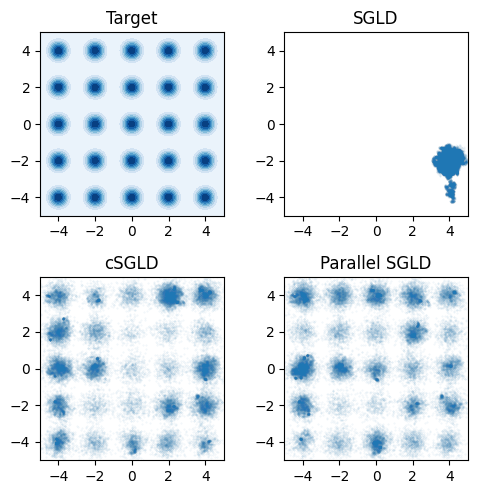

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6.3*0.8, 6.3*0.8))
for ax in axs.flat:
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_yticks([-4, -2, 0, 2, 4])
    ax.set_aspect('equal')

xx, yy = np.mgrid[-5:5:300j, -5:5:300j]
points = np.vstack([xx.ravel(), yy.ravel()]).T
dens = jax.vmap(lambda x: jnp.exp(logprob_fn(x)))(points)

ax = axs.flat[0]
ax.contourf(xx, yy, dens.reshape(300, 300), cmap='Blues')
ax.set_title("Target")

ax = axs.flat[1]
# ax.contourf(xx, yy, f_sgld, cmap='Blues')
ax.scatter(sgld_samples[:, 0], sgld_samples[:, 1], s=0.1, alpha=0.1)
ax.set_title("SGLD")

ax = axs.flat[2]
ax.scatter(cyclical_samples[:, 0], cyclical_samples[:, 1], s=0.1, alpha=0.1)
ax.set_title("cSGLD")

ax = axs.flat[3]
ax.scatter(parallel_samples[:, 0], parallel_samples[:, 1], s=0.1, alpha=0.1)
for init_state in init_states:
    ax.scatter(init_state.position[0], init_state.position[1], s=10, color='red', marker='x')
ax.set_title("Parallel SGLD")

fig.tight_layout()
# plt.savefig("../ba/images/toy_example.pdf", bbox_inches="tight")

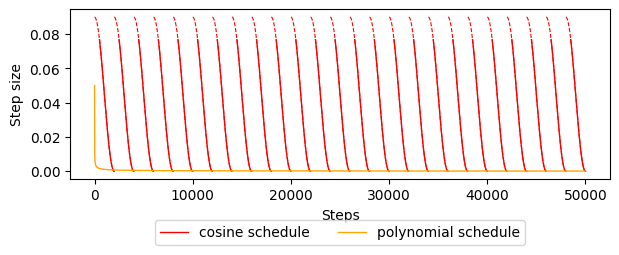

In [ ]:
fig, ax = plt.subplots(figsize=(6.3, 6.3/2.3))
cosine_schedule, _ = build_schedule(num_training_steps, 25, 0.09, 0.25)
schedule_cosine = [cosine_schedule(i) for i in range(num_training_steps)]
step_sizes_cosine = np.array([step.step_size for step in schedule_cosine])
do_sample = np.array([step.do_sample for step in schedule_cosine])
sample_points_cosine = np.ma.masked_where(~np.array(do_sample), step_sizes_cosine)

for i in range(25):
    step_sizes_cosine_i = step_sizes_cosine[i * (num_training_steps // 25):(i + 1) * (num_training_steps // 25)]
    sample_points_cosine_i = sample_points_cosine[i * (num_training_steps // 25):(i + 1) * (num_training_steps // 25)]
    xs = np.arange(i * (num_training_steps // 25), (i + 1) * (num_training_steps // 25))
    ax.plot(xs, step_sizes_cosine_i, lw=0.8, ls="--", color="r")
    ax.plot(xs, sample_points_cosine_i, lw=1, ls="-", color="r", label="cosine schedule")

ax.plot(schedule_sgld, lw=1, ls="-", color="orange", label="polynomial schedule")
ax.set_xlabel("Steps")
ax.set_ylabel("Step size")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
fig.tight_layout()
# fig.savefig("../ba/images/toy_schedules.pdf", bbox_inches="tight")